# Machine Learning II - Individual Assignment - HR Analytics Logistic Regression, Feature Engineering

The present work is based on the **HR Analytics Dataset**, which contains information about around 15.000 employees of a large company. The purpose of the case study is to model the **probability of attrition** (or churn, either because they leave or because they get fired) of each employee, and to understand which explanatory variables are the most important ones and need to be addressed in the right way. In order to reach this objective, we will use a **logistic regression model**.


## Table of contents

0. Importing the libraries needed <br>
1. Building the pipeline <br>
    1.1. Definition of the pipeline function <br>
2. Data Loading <br>
    2.1. Reading the csv and getting the first info on the dataset <br>
3. Exploratory Data Analysis<br>
    3.1. Correlation Matrix <br>
	3.2. Histogram of the satisfaction level <br>
	3.3. Distribution of the satisfaction Level (colour-coded: showing who stayed/who left) <br>
	3.4. Boxplot of the Satisfaction Level<br>
	3.5. Distribution of employees based on salary, displaying who stayed and who left<br>
	3.6. Time Spent and Churn<br>
	3.7.  Distribution of  "last evaluation" (colour-coded: showing who stayed/who left) <br>
	3.8. Distribution of "average monthly hours"" (colour-coded: showing who stayed/who left) <br>
    3.9. Distribution of "n. of projects" (colour-coded: showing who stayed/who left)
	3.10. Analyzing the turnover rate<br>
	3.11. Some more exploration<br>
4. Data Preparation<br>
	4.1. Fixing Skewness<br>
5. Prepare data pipeline<br>
6. Logistic Regression Model<br>
	6.1. Feature Engineering<br>
	6.2. Fixing underepresentation<br>
	6.3. Cross Validation Evaluation<br>
7. Run the whole process<br>


   

    


	


### 0. Importing the libraries needed 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from sklearn import preprocessing
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore')

## 1. Building the pipeline

### 1.1. Definition of the pipeline function

In [2]:
def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > - 0.0001:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions, engineered_data

## 2. Data loading

### 2.1. Reading the csv and getting the first info on the dataset

In [3]:
#reading the csv document from the gist
raw=pd.read_csv('https://gist.githubusercontent.com/francescamanoni/0916de17c8e957dd7e10e712871adaa7/raw/57680224b520390a46ff8852d5634170c735989d/turnover.csv')
raw.info()
raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
#Converting numerical variables into booleans
raw["left"] = raw["left"].astype('bool')
raw["Work_accident"] = raw["Work_accident"].astype('bool')
raw["promotion_last_5years"] = raw["promotion_last_5years"].astype('bool')
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null bool
left                     14999 non-null bool
promotion_last_5years    14999 non-null bool
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: bool(3), float64(2), int64(3), object(2)
memory usage: 864.3+ KB


## 3. Exploratory Data Analysis


### 3.1. Correlation Matrix

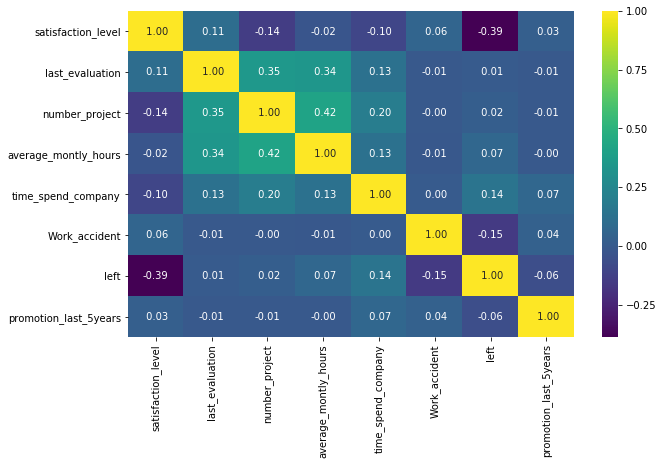

In [5]:
#Plotting the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(raw.corr(),cbar=True,fmt =' .2f', annot=True, cmap='viridis')

### 3.2. Histogram of the satisfaction level

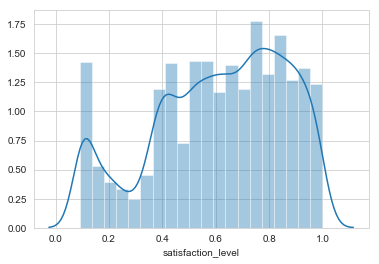

In [6]:
sns.set_style('whitegrid')
sns.distplot(raw['satisfaction_level'],bins=20)

### 3.3. Boxplot of the Satisfaction Level

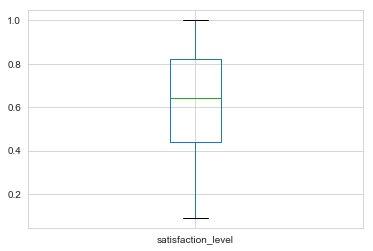

In [7]:
raw.satisfaction_level.plot(kind='box')


### 3.4. Distribution of the satisfaction Level (colour-coded: showing who stayed/who left)

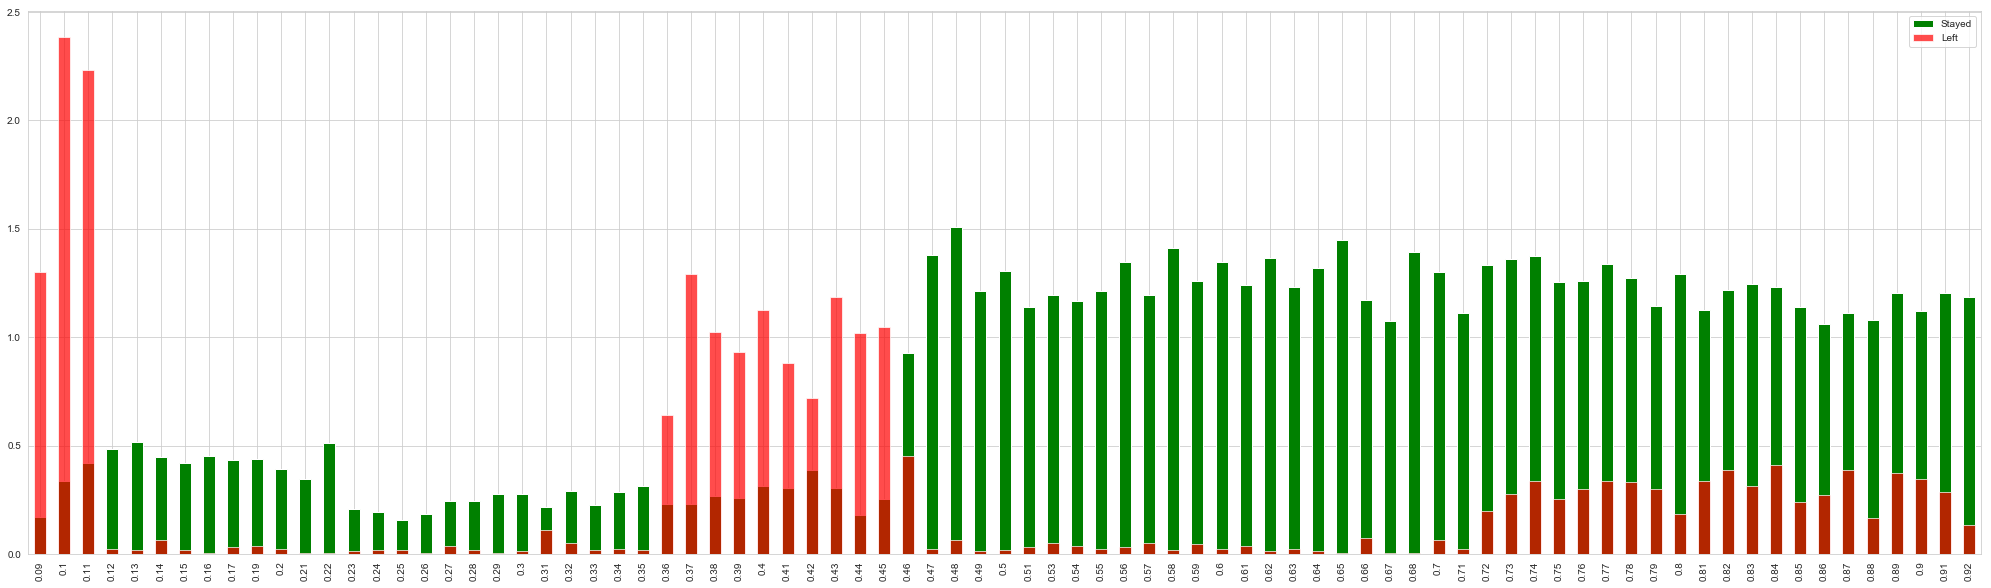

In [8]:
sat_level_temp = raw.satisfaction_level
sat_level_temp = sat_level_temp.astype('category')
ax = pd.Series((raw[raw.left==0].satisfaction_level.value_counts()/len(raw.left))*100).sort_index().plot(kind='bar',color='g',figsize=(35,10))
pd.Series((raw[raw.left==1].satisfaction_level.value_counts()/len(raw.left))*100).sort_index().plot(kind='bar',color='r',alpha= 0.7,figsize=(35,10), ax=ax)
ax.legend(["Stayed", "Left"])


### 3.5. Distribution of employees based on salary, displaying who stayed and who left


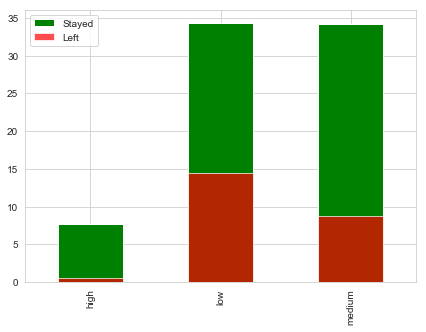

In [9]:

plt.figure(figsize=(7,5))
ax = ((raw[raw.left==0].salary.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='g')
((raw[raw.left==1].salary.value_counts().sort_index()/len(raw.left)*100)).plot(kind='bar',color='r',alpha= 0.7, ax= ax)
ax.legend(["Stayed", "Left"])


### 3.6. Time Spent and Churn

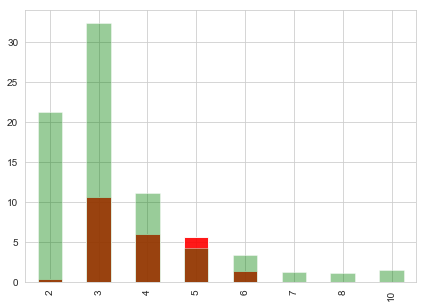

In [10]:
plt.figure(figsize=(7,5))
((raw[raw.left==1].time_spend_company.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='r', alpha=0.9)
((raw[raw.left==0].time_spend_company.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='g',alpha=0.4)


### 3.7.  Distribution of  "last evaluation" (colour-coded: showing who stayed/who left)

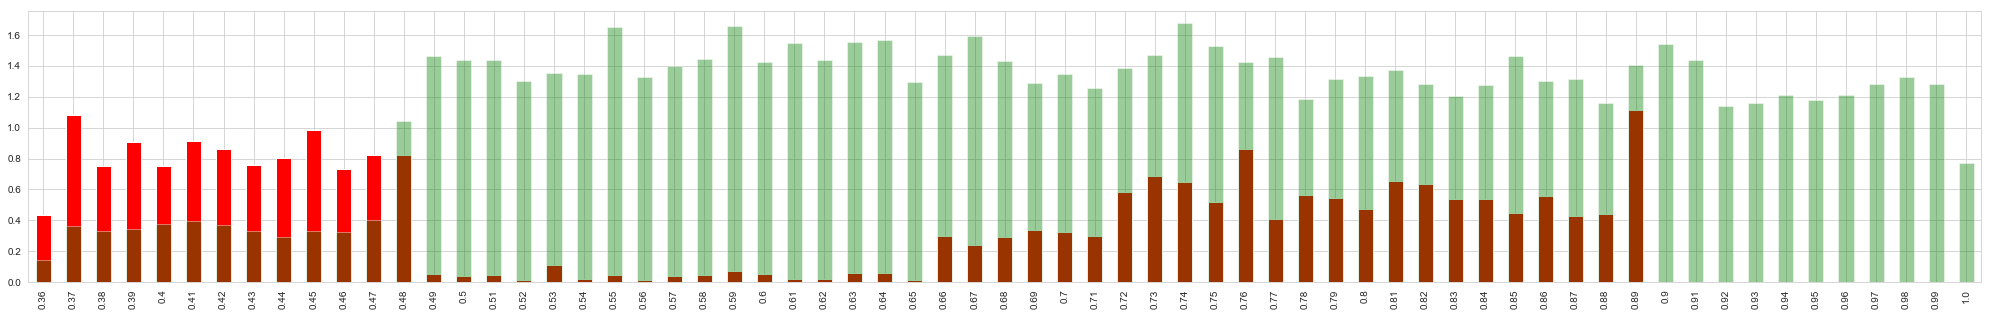

In [11]:
plt.figure(figsize=(35,5))
((raw[raw.left==1].last_evaluation.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='r')
((raw[raw.left==0].last_evaluation.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='g',alpha=0.4)


### 3.8. Distribution of "average monthly hours"" (colour-coded: showing who stayed/who left)

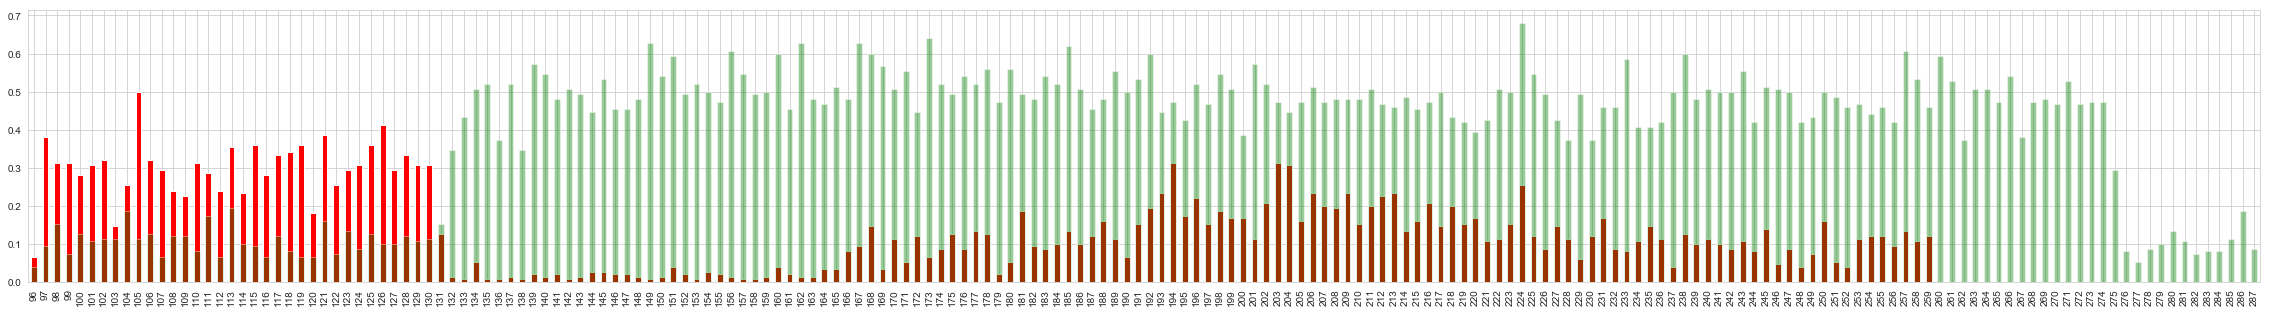

In [12]:
plt.figure(figsize=(40,5))
((raw[raw.left==1].average_montly_hours.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='r')
((raw[raw.left==0].average_montly_hours.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='g',alpha=0.4)


### 3.9. Distribution of "n. of projects" (colour-coded: showing who stayed/who left)

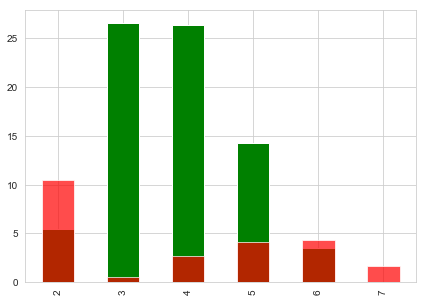

In [13]:
plt.figure(figsize=(7,5))
((raw[raw.left==0].number_project.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='g')
((raw[raw.left==1].number_project.value_counts().sort_index()/len(raw.left))*100).plot(kind='bar',color='r',alpha=0.7)


### 3.10. Analyzing the turnover rate

In [14]:
# Get the total number of observations and save it
n_employees = len(raw)

# Print the number of employees who left/stayed
print(raw.left.value_counts())



False    11428
True      3571
Name: left, dtype: int64


In [15]:
# Print the percentage of employees who left/stayed
print(raw.left.value_counts()/n_employees*100)

False    76.191746
True     23.808254
Name: left, dtype: float64


### 3.11. Some more exploration:

In [16]:
raw.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
False,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
True,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


## 4. Data Preparation

### 4.1. Fixing Skewness

In [17]:
def feature_skewness(df):
    numeric_dtypes = ['int64', 
                      'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

In [18]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

## 5. Prepare data Pipeline

In [19]:
prepared = fix_skewness(raw)
print('Original shape before onehot encoding: {}'.format(prepared.shape))
dataset = pd.get_dummies(prepared)
print('Dataset shape AFTER onehot encoding: {}'.format(dataset.shape))

dataset.head()

Original shape before onehot encoding: (14999, 10)
Dataset shape AFTER onehot encoding: (14999, 21)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,0.886558,False,True,False,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,1.061627,False,True,False,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,0.964686,False,True,False,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,1.020041,False,True,False,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,0.886558,False,True,False,0,0,...,0,0,0,0,1,0,0,0,1,0


## 6. Logistic Regression Model

In [20]:
def score_model(data, seed=666):
    X = data.loc[:, data.columns != 'left']
    y = data.loc[:, 'left']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create log regression object
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    return logreg.score(X_test,y_test)

In [21]:
#Checking the accuracy of the baseline model
score_model(dataset)

0.8073333333333333

## 6.1. Feature Engineering 

In [22]:
#Dataset description, to understand how to do the bins
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,0.904329,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.232592,49.943099,0.096379,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,2.000000,96.000000,0.765994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,0.886558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,0.886558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,0.964686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,1.160577,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 6.1.1. Feature creation functions

Based on the graphs that we plotted above, we will bin some variables in order to remove linearity

In [23]:
#function definition
#number of projects
def nproj(df):
    lkup = {  2: "min", 3: "low", 4 : "medium", 5 : "medium-high",  6: "high", 7: "Very high"}
    df['number_project_cat'] = df['number_project'].map(lkup)

    df = pd.concat([df, pd.get_dummies(df['number_project_cat'],prefix='np', prefix_sep='_')], axis=1)
    df.drop('number_project_cat', inplace=True, axis=1)
    df.drop('number_project', inplace=True, axis=1)
    return df


#time spent binning
def time_spent(df):
    df_NK = df.copy()

    bins = [0, 0.765994, 0.886558, 0.964686, 1.160577]
    df_NK['time_spend_company_bin'] = pd.cut(df_NK.time_spend_company,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['time_spend_company_bin'],prefix='timesp', prefix_sep='_')], axis=1)
    df_NK.drop('time_spend_company_bin', inplace=True, axis=1)
    df_NK.drop('time_spend_company', inplace=True, axis=1)
    return df_NK

#average monthly hours
def average_mh(df):
    df_NK = df.copy()

    bins = [96, 131, 165, 178, 179, 259, 287]
    df_NK['average_montly_hours_bin'] = pd.cut(df_NK.average_montly_hours,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['average_montly_hours_bin'],prefix='avmh', prefix_sep='_')], axis=1)
    df_NK.drop('average_montly_hours_bin', inplace=True, axis=1)
    df_NK.drop('average_montly_hours', inplace=True, axis=1)
    return df_NK

#satisfaction_level bins

def satisf(df):
    df_NK = df.copy()

    bins = [0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
    df_NK['satisfaction_level_bin'] = pd.cut(df_NK.satisfaction_level,bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['satisfaction_level_bin'],prefix='sat', prefix_sep='_')], axis=1)
    df_NK.drop('satisfaction_level_bin', inplace=True, axis=1)
    df_NK.drop('satisfaction_level', inplace=True, axis=1)
    return df_NK

#last_evaluation bins

def last_el(df):
    df_NK = df.copy()

    bins = [0, 0.47, 0.48, 0.65, 0.88, 0.89,1.0]
    df_NK['last_evaluation_bin'] = pd.cut(df_NK.last_evaluation, bins)
    
    df_NK = pd.concat([df_NK, pd.get_dummies(df_NK['last_evaluation_bin'],prefix = 'le', prefix_sep = '_')], axis = 1)
    df_NK.drop('last_evaluation_bin', inplace = True, axis = 1)
    df_NK.drop('last_evaluation', inplace = True, axis = 1)
    return df_NK


### 6.2. Fixing underepresentation

In this step we eliminate those columns in which most of the information belong to the same class


In [24]:
def under_represented_features(df):
    under_rep = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if ((zeros / len(df)) * 100) > 99.0:
            under_rep.append(i)
    df.drop(under_rep, axis=1, inplace=True)
    return df

### 6.3. Cross Validation Evaluation

In [25]:
def cv_evaluate(df, splits=100):
    lr = LogisticRegression()
    kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

    X = df.drop(['left'], axis=1)
    y = df.left.reset_index(drop=True)
    benchmark_model = make_pipeline(RobustScaler(), lr).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='accuracy', cv=kfolds)
    return scores[scores>=0.0]

## 7. Run the whole process

In [28]:
fe_functions = ['nproj','under_represented_features', 'time_spent', 'average_mh', 'satisf', 'last_el']
funcs, new_dataset = feature_engineering_pipeline(dataset, fe_functions)


accuracy = cv_evaluate(new_dataset, splits=100)
print('Mean accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))

Base Score: 0.8073
- New Score (nproj): 0.8583 [diff: 0.0510] [Accepted]
- New Score (under_represented_features): 0.8583 [diff: 0.0000] [Accepted]
- New Score (time_spent): 0.8800 [diff: 0.0217] [Accepted]
- New Score (average_mh): 0.8913 [diff: 0.0113] [Accepted]
- New Score (satisf): 0.9567 [diff: 0.0653] [Accepted]
- New Score (last_el): 0.9533 [diff: -0.0033] [Rejected]
Mean accuracy after CV: 0.955 +/- 0.005
